<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:400px;" width=500px/></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h3 style="text-align: center;"><b>Домашнее задание: сегментация изображений</b></h3>

---

<h3 style="text-align: center;"><b>Условие</b></h3>

В качестве домашней работы предлагается улучшить сегментацию, сделанную на семинаре. В качестве основы для даталоэдера используйте функцию __keras_generator__. Попробуйте сделать следующие улучшения:
1. Брать случайный кроп, а не ресайзить исходное изображение. Попробуйте разные размеры кропов, на каких результат получается лучше? Кроп какого максимального размера помещается в вашу видеокарту?
2. Добавить аугментаций. Например, можно поворачивать картинки или добавлять случайный шум

Эти два пункта улучшения можно сделать с помощью библиотеки __albumentations__ https://github.com/albu/albumentations . Пример использования можно посмотреть в конце семинарского ноутбука.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls

data  gdrive  sample_data


In [0]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [0]:
def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        RandomRotate90(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),

    ],
        p=p)

augmentation = strong_aug(p=1.0)


Подумайте, нужно ли применять аугментации для валидационной выборки или это стоит делать только для тренировки? Возможно, следует добавить в аргументы __keras_generator__ флаг, который будет говорить, применять аугментации или нет.
3. В качестве модели машинного обучения предлагается взять либо модель с семинара, либо какую-нибудь готовую реализацию, например из __segmentation_models__ https://github.com/qubvel/segmentation_models . Пример использования:

In [6]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-6okogss3
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-6okogss3
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-4rcau4mc/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [7]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/[11]segmentation/data'

Archive:  /content/gdrive/My Drive/Colab Notebooks/[11]segmentation/data.zip
replace data/train/00087a6bd4dc_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/train/00087a6bd4dc_01.jpg  
  inflating: data/train/00087a6bd4dc_02.jpg  
  inflating: data/train/00087a6bd4dc_03.jpg  
  inflating: data/train/00087a6bd4dc_04.jpg  
  inflating: data/train/00087a6bd4dc_05.jpg  
  inflating: data/train/00087a6bd4dc_06.jpg  
  inflating: data/train/00087a6bd4dc_07.jpg  
  inflating: data/train/00087a6bd4dc_08.jpg  
  inflating: data/train/00087a6bd4dc_09.jpg  
  inflating: data/train/00087a6bd4dc_10.jpg  
  inflating: data/train/00087a6bd4dc_11.jpg  
  inflating: data/train/00087a6bd4dc_12.jpg  
  inflating: data/train/00087a6bd4dc_13.jpg  
  inflating: data/train/00087a6bd4dc_14.jpg  
  inflating: data/train/00087a6bd4dc_15.jpg  
  inflating: data/train/00087a6bd4dc_16.jpg  
  inflating: data/train/02159e548029_01.jpg  
  inflating: data/train/02159e548029_02.jpg  
  inflating: da

In [8]:
!ls

data  gdrive  sample_data


In [9]:
df = pd.read_csv('data/train_masks.csv')
df.shape

(5088, 2)

In [0]:
train_df = df[:4000]
val_df = df[4000:]

In [0]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img


In [0]:
import random

In [0]:
img_name, mask_rle = train_df.iloc[random.randint(0, 4000-1)]

img = cv2.imread('data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

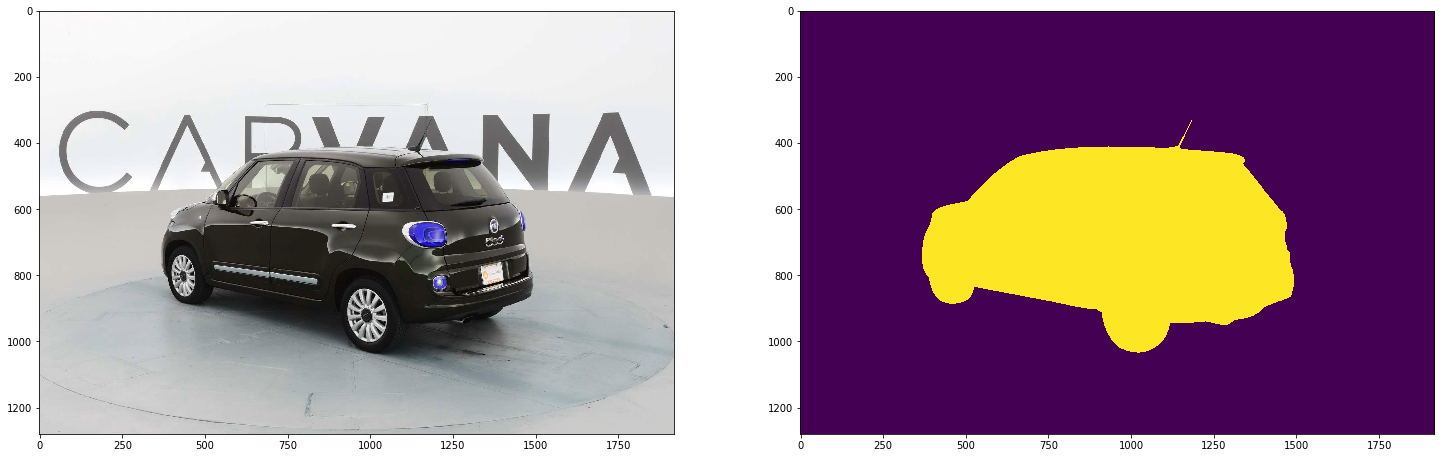

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

In [0]:
def keras_generator(gen_df, batch_size, aug = False, augmentation = strong_aug(p=1.0)):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            if aug:
              data = {'image': img, 'mask': mask}
              augmented = augmentation(**data)
              img, mask = augmented["image"], augmented["mask"]
              img = cv2.resize(img, (256, 256))
              mask = cv2.resize(mask, (256, 256))
            else:
              img = cv2.resize(img, (256, 256))
              mask = cv2.resize(mask, (256, 256))
                
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        
        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
for x, y in keras_generator(train_df, 500, aug = True, augmentation = strong_aug(p=0.5)):
    break

In [78]:
print(x.shape)
print(y.shape)

(500, 256, 256, 3)
(500, 256, 256, 1)


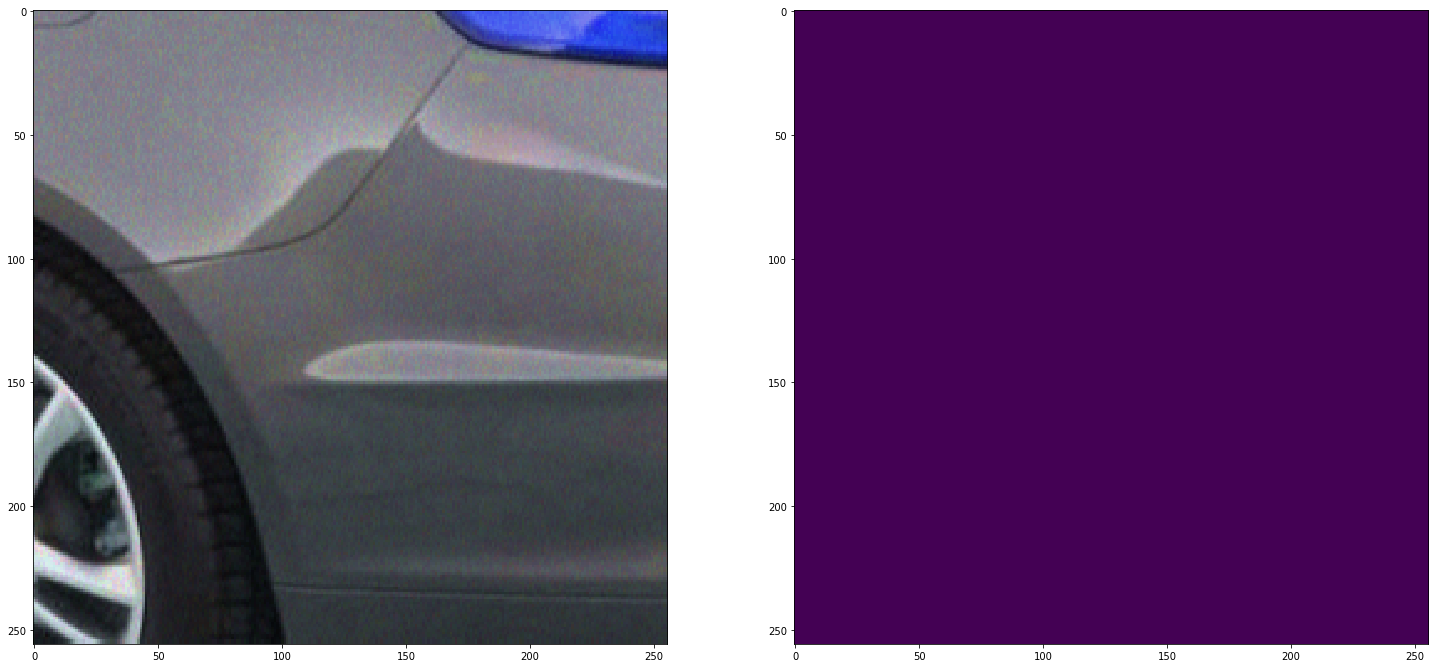

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
u = random.randint(0, 499)
axes[0].imshow(x[u])
axes[1].imshow(y[u][..., 0])

plt.show()

In [0]:
for x_val, y_val in keras_generator(val_df, 42, aug = False):
    break

In [81]:
print(x_val.shape)
print(y_val.shape)

(42, 256, 256, 3)
(42, 256, 256, 1)


In [114]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

# prepare data
#x, y = ...
BACKBONE = 'resnet50'

preprocessing_fn = get_preprocessing('resnet34')
x = preprocessing_fn(x)
x_val = preprocessing_fn(x_val)

# prepare model
#model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
#model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

model = Unet(backbone_name=BACKBONE, encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

94593024/94592056 [==============================] - 1s 0us/step


В качестве базового энкодера на семинаре использовался __resnet50__. Поэкспериментируйте с разными энкодерами, например, __VGG16__, __densenet121__. Какой дает лучшее качество?

Итак, вы обучили модель предсказывать кропы, например, размера 256x256, качество мерили тоже на кропах. Но как исходная цель - нужно уметь делать предсказания на всю картинку. Как решить проблему и есть ли она вообще? Первый приходящий в голову вариант - можно проходиться по картинке окном в 256x256 пикселей и сохранять предсказания на всю большую картинку. Но можно сделать проще, если ответить на вопрос: работает ли полностью сверточная сеть на картинках произвольного размера(с добиванием до кратности паддингами)? Почему не работали сети для классификации?

4. Напоследок, можете попробовать технику под названием __Test Time Augmentation__. Сделайте предсказание картинки, сохраните его. Попробуйте сделать flip картинки, и предсказать флипнутое изображение. Что будет если усреднить результаты этих двух предсказаний? Улучшится ли качество?

---

<h3 style="text-align: center;"><b>Ваше решение</b></h3>

In [115]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
conv1 = model.get_layer('relu0').output
# conv2 = base_model.get_layer('activation_137').output
# conv3 = base_model.get_layer('activation_147').output
# conv4 = base_model.get_layer('activation_160').output
# conv5 = base_model.get_layer('activation_175').output

In [118]:
conv1

<tf.Tensor 'relu0/Relu:0' shape=(?, ?, ?, 64) dtype=float32>

In [84]:
model.fit(x=x, y=y, batch_size=16, epochs=42, validation_data=(x_val, y_val))

Train on 500 samples, validate on 42 samples
Epoch 1/42
500/500 [==============================] - 69s 138ms/step - loss: 0.3622 - binary_accuracy: 0.8500 - val_loss: 0.5703 - val_binary_accuracy: 0.8640
Epoch 2/42
500/500 [==============================] - 14s 29ms/step - loss: 0.2594 - binary_accuracy: 0.8995 - val_loss: 0.3350 - val_binary_accuracy: 0.9176
Epoch 3/42
500/500 [==============================] - 14s 28ms/step - loss: 0.2358 - binary_accuracy: 0.9086 - val_loss: 0.1282 - val_binary_accuracy: 0.9623
Epoch 4/42
500/500 [==============================] - 14s 28ms/step - loss: 0.2176 - binary_accuracy: 0.9133 - val_loss: 0.3096 - val_binary_accuracy: 0.9357
Epoch 5/42
500/500 [==============================] - 14s 28ms/step - loss: 0.1957 - binary_accuracy: 0.9222 - val_loss: 0.2775 - val_binary_accuracy: 0.9436
Epoch 6/42
500/500 [==============================] - 14s 28ms/step - loss: 0.1911 - binary_accuracy: 0.9259 - val_loss: 7.2435 - val_binary_accuracy: 0.4389
Epoch 

In [0]:
pred = model.predict(x)#.shape

im_id =  52


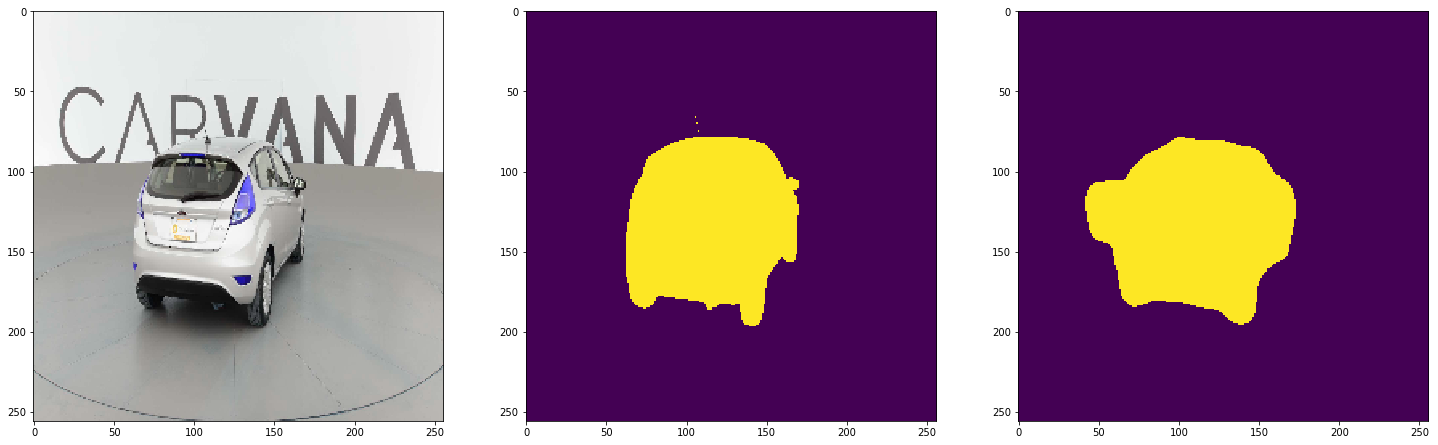

In [110]:
im_id = random.randint(0, x.shape[0]-1)
print('im_id = ', im_id)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(y[im_id, ...,0])
axes[2].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

In [0]:
pred = model.predict(x_val)#.shape

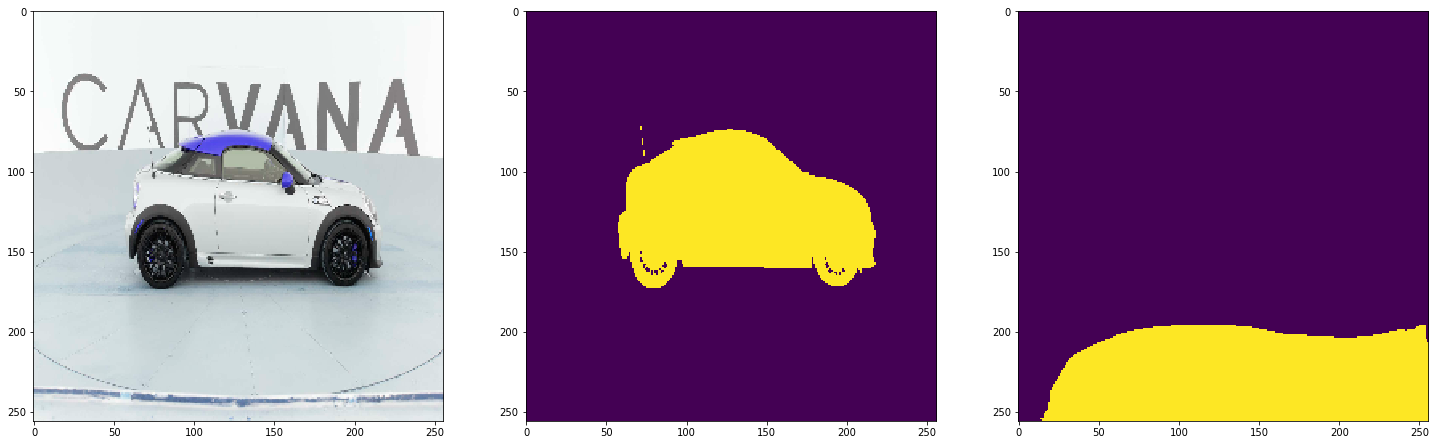

In [113]:
im_id = random.randint(0, 41)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 25))
axes[0].imshow(x_val[im_id])
axes[1].imshow(y_val[im_id, ...,0])
axes[2].imshow(pred[im_id, ..., 0] >0.5)

plt.show()